# HW-2 Question-2

In [ ]:
import numpy as np
import pandas as pd
import csv
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import CountVectorizer
import networkx as nx

In [ ]:
#Load data from csv file
from google.colab import files

#Run once to upload google platform
filename = files.upload()

#Alternative to load edges
#f = open(filename, "rb")
#g = nx.read_edgelist(f)


#load the data into dataframe
df = pd.read_csv("book1.csv")

#Get data
df.shape

#verify data import
df.head(2)

Saving book1.csv to book1.csv


,Source,Target,Type,weight,book
0,Addam-Marbrand,Jaime-Lannister,Undirected,3,1
1,Addam-Marbrand,Tywin-Lannister,Undirected,6,1


In [ ]:
#Drop unused columns to simplify the dataset
#Do not fail if cell re-run
#Shape the data 

def drop_unused_columns(df):
  columns = ['Source', 'Target']
  df[columns].head(3)

  try:
   df = df.drop(['Type', 'weight', 'book'], axis=1)
  except:
   pass

  #verify
  #df.head(3)

  return df


In [ ]:
#shape the dataset
df = drop_unused_columns(df)

#Verify data
df.shape


(684, 2)

In [ ]:
# Create new column for feature
def get_features(data):
  
  #new list of features
  features = []
  for i in range(0, data.shape[0]):
    features.append(data['Source'][i]+' '+data['Target'][i])
  
  return features

In [ ]:
#Returns Common Neighbors Similarity
def get_cn_similarity_coefficient(u, v, g):
    u_neighbors = set(g.neighbors(u))
    v_neighbors = set(g.neighbors(v))
    return len(u_neighbors.intersection(v_neighbors))

In [ ]:
#Returns Preferential Attachment Similarity
def get_pa_similarity_coefficient(u, v, g):
    return g.degree(u)*g.degree(v)

In [ ]:
#Returns Jaccard Similarity
def get_jaccard_similarity_coefficient(u, v, g):
    u_neighbors = set(g.neighbors(u))
    v_neighbors = set(g.neighbors(v))
    return len(u_neighbors.intersection(v_neighbors)) / float(len(u_neighbors.union(v_neighbors)))

In [ ]:
#Returns Katz coefficient for
#Lmax=3 and beta (β) = 0.85
# n is neighbors 
#kMap is neighbors map
def get_katz_similarity_coefficient(u, v, kMap, Lmax=3, beta=0.85):
    n = kMap[u]
    score = 0
    for l in range(1, Lmax):
        path = n.count(v)
        if path > 0:
            score = score + (beta**l)*path

        #build possible next neighbors
        n_next = []
        for k in n:
            n_next += kMap[k]
        n = n_next
        l = l+1

    return score

In [ ]:
# Prepares the Graph
def prepare_graph(t_data):
  #  list(t_data)
    G = nx.Graph()
    G.add_edges_from(t_data)
    
    #verify
    nx.draw(G)
    
    return G

In [ ]:
myTuple = list(df.itertuples(index=False))
list(myTuple)

[Pandas(Source='Addam-Marbrand', Target='Jaime-Lannister'),
 Pandas(Source='Addam-Marbrand', Target='Tywin-Lannister'),
 Pandas(Source='Aegon-I-Targaryen', Target='Daenerys-Targaryen'),
 Pandas(Source='Aegon-I-Targaryen', Target='Eddard-Stark'),
 Pandas(Source='Aemon-Targaryen-(Maester-Aemon)', Target='Alliser-Thorne'),
 Pandas(Source='Aemon-Targaryen-(Maester-Aemon)', Target='Bowen-Marsh'),
 Pandas(Source='Aemon-Targaryen-(Maester-Aemon)', Target='Chett'),
 Pandas(Source='Aemon-Targaryen-(Maester-Aemon)', Target='Clydas'),
 Pandas(Source='Aemon-Targaryen-(Maester-Aemon)', Target='Jeor-Mormont'),
 Pandas(Source='Aemon-Targaryen-(Maester-Aemon)', Target='Jon-Snow'),
 Pandas(Source='Aemon-Targaryen-(Maester-Aemon)', Target='Samwell-Tarly'),
 Pandas(Source='Aerys-II-Targaryen', Target='Brandon-Stark'),
 Pandas(Source='Aerys-II-Targaryen', Target='Eddard-Stark'),
 Pandas(Source='Aerys-II-Targaryen', Target='Gerold-Hightower'),
 Pandas(Source='Aerys-II-Targaryen', Target='Jaime-Lannister'),

In [ ]:
# Prepares Training and Test data
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_blobs

def prepare_data(dataset):
    training_data, testing_data = train_test_split(dataset, test_size=0.2, random_state=25)
    
    return training_data, testing_data

In [ ]:
# Create a new file for each result
def write_csv(data, filename):
  from google.colab import files
  csvfile = open(filename, "w")
  writer = csv.writer(csvfile)
  for i in data:
    writer.writerow(i)
    
  csvfile.close()

  #files.upload(filename)

In [ ]:
# Build recommendation data to write to csv file
def export_similarity_data(data, similarity_name, top=3):
    write_csv(data, similarity_name+ "_" + str(top) + ".csv")
    return data

In [ ]:
#List top n recommendation
def export_Top(sorted_scores, similarity_name, top=3):
  i=0
  recomended = []
  for item in sorted_scores:
    recomended.append(sorted_scores[i])
    if i > top:
      break
    i=i+1

  export_similarity_data(recomended, similarity_name)


In [ ]:
#Create list of enums for the similarity score.
def enumerate_scores(cs):
  try:
    scores = list(enumerate(cs))
    sorted_scores = sorted(scores,key=lambda x:x[1], reverse= True)
    sorted_scores = sorted_scores[1:]
  
  except:
    pass

  return sorted_scores


In [ ]:
def generate_empty_matrix(G):
  number_of_node = G.number_of_nodes()
  return [[0 for _ in range(number_of_node)] for _ in range(number_of_node)]

In [ ]:
#Construct Katz Similarity Data
def construct_katz_similarity(G):
  #create unique set for training data:
  train_set = set(nx.nodes(G))
  number_of_node = G.number_of_nodes()
    
  # adjacency map
  kMap = {}
  adjList = list(G.edges())
  
  #set 1 row/index 
  for row, l in enumerate(adjList):
      kMap[row] = l

  #create nxn empty matrix   
  sMatrix  = generate_empty_matrix(G)

  #populate similarity data using katz coefficient 
  for u in range(number_of_node):
    if u in train_set:
      for v in range(u + 1, number_of_node):
        if v in train_set:
            sMatrix[u][v] = sMatrix[v][u] = get_katz_similarity_coefficient(kMap, u, v)
 
  # todo generate resultset and return.
  return

In [ ]:
#Construct CN Similarity Data
def construct_cn_similarity(G):

  #make unique set of nodes
  train_set = set(nx.nodes(G))
  number_of_node = G.number_of_nodes()

  #list to iterate
  train_list = list(train_set)

  #return list of scores for node u
  scores = []

  #similarity score of each u node                      
  for u in train_list:
    for v in train_list:
      if u!=v: #ignore itself
        cs = get_cn_similarity_coefficient(u, v, G)
        #print(cs)
        
        #build tuple for each node and add to the list 
        result_tuple = (v,cs)
        scores.append(result_tuple)
    return scores     

In [ ]:
#Construct PA Similarity Data
def construct_pa_similarity(G):

  #make unique set of nodes
  train_set = set(nx.nodes(G))
  number_of_node = G.number_of_nodes()

  #list to iterate
  train_list = list(train_set)

  #return list of scores for node u
  scores = []

  #similarity score of each u node                      
  for u in train_list:

    for v in train_list:
      if u!=v: #ignore itself
        cs = get_pa_similarity_coefficient(u, v, G)
        
        #build tuple for each node and add to the list 
        result_tuple = (v,cs)
        scores.append(result_tuple)
    return scores   

In [ ]:
#Construct Jaccard Similarity Data
def construct_jaccard_similarity(G):

  #make unique set of nodes
  train_set = set(nx.nodes(G))
  number_of_node = G.number_of_nodes()

  #list to iterate
  train_list = list(train_set)

  #return list of scores for node u
  scores = []

  #similarity score of each u node                      
  for u in train_list:

    for v in train_list:
      if u!=v: #ignore itself
        cs = get_jaccard_similarity_coefficient(u, v, G)
        #print(cs)

        #build tuple for each node and add to the list 
        result_tuple = (v,cs)
        scores.append(result_tuple)
    return scores 

In [ ]:
#Main function for Katz Similarity
def deploy_katz_similarity(G, top):
  scores = construct_katz_similarity(G)
  
  #manipulate the resultset
  sorted_scores = enumerate_scores(scores)

  #export it
  export_Top(sorted_scores, "katz_similarity", top)



In [ ]:
#Main function for CN Similarity
def deploy_cn_similarity(G, top):
  scores = construct_cn_similarity(G)
  print(scores)
  
  #manipulate the resultset
  sorted_scores = enumerate_scores(scores)

  #export it
  export_Top(sorted_scores, "cn_similarity", top)



In [ ]:
#Main function for PA Similarity
def deploy_pa_similarity(G, top):
  scores = construct_pa_similarity(G)
  
  #manipulate the resultset
  sorted_scores = enumerate_scores(scores)

  #export it
  export_Top(sorted_scores, "pa_similarity", top)



In [ ]:
#Main function for Jaccard Similarity
def deploy_jaccard_similarity(G, top):
  scores = construct_jaccard_similarity(G)
  
  #manipulate the resultset
  sorted_scores = enumerate_scores(scores)

  #export it
  export_Top(sorted_scores, "jaccard_similarity", top)

In [ ]:
#Main program to drive &execute the code for k=3
#Create an nx Graph

#expecting an nx Graph and top # of recs for each type

try:
  #construct and export common neighbors similarity data
  deploy_cn_similarity(G, 3)

  #construct and export common neighbors similarity data
  deploy_pa_similarity(G, 3)

  #construct and export common neighbors similarity data
  deploy_jaccard_similarity(G, 3)

  #construct and export common neighbors similarity data
  deploy_katz_similarity(G, 3)


except:
  pass




# HW-2 Question-4

In [ ]:
#Read in the dataset
import numpy as np
import pandas as pd
import csv
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import CountVectorizer
import networkx as nx
from scipy.sparse.linalg import eigs
import scipy

from google.colab import files

#upoad the file if needed.
#Only once per session. 
file = files.upload()

#store the data
df2 = pd.read_csv("book1.csv")

#verify data import
print("A few lines from the csv file")
df2.head(3)


Saving book1.csv to book1 (1).csv
A few lines from the csv file


,Source,Target,Type,weight,book
0,Addam-Marbrand,Jaime-Lannister,Undirected,3,1
1,Addam-Marbrand,Tywin-Lannister,Undirected,6,1
2,Aegon-I-Targaryen,Daenerys-Targaryen,Undirected,5,1


In [ ]:
#Drop unused columns to simplify the dataset
#Do not fail if cell re-runs
#Shape the data 

def drop_unused_columns(df2):
  columns = ['Source', 'Target']
  df[columns].head(3)

  try:
   df2 = df2.drop(['Type', 'weight', 'book'], axis=1)
  except:
   pass

  #verify
  #df.head(3)

  return df2

In [ ]:
#Shape the data and then tokenize matrix
def shape_data(df2):

  #shape the dataset
  df2 = drop_unused_columns(df2)

  #verify
  print("The Shape of Dataframe after shape")
  df2.shape

  #Generate global duple to work with data
  myTuple2 = list(df2.itertuples(index=False))

  print("Lines of df2")
  myTuple2= sorted(list(myTuple2))

  return df2, myTuple2

In [ ]:
# Prepare the graph
def prepare_graph(t_data):
    #list(t_data)
    G = nx.Graph()
    G.add_edges_from(t_data)
    
    return G

In [ ]:
#Extract the adjacency matrix A
#Create and nx Graph
#list(myTuple2)

def construct_adj_matrix(G2):

  
  #G = prepare_graph(myTuple2)

  #Verify Graph
  nx.draw(G2)

  #Using nx is not prohibited in Q2
  A = nx.adjacency_matrix(G2,nodelist=sorted(G2.nodes())).astype('float').todense()

  #Verify Adj Matrix
  
  print("Adjacency Matrix")
  print(A)  #already todense()
  A.shape

  return A

In [ ]:
#Construct Degree vector
# Replace by np.diag(np.sum(np...))
def get_degree_vector(G2):
  #degree_vector = [val for (node, val) in sorted(G2.degree(), key=lambda pair: pair[0])]
  degree_vector = nx.adjacency_matrix(G2,nodelist=sorted(G2.nodes())).astype('float').todense()
 
  print("Degree Vector")
  print(degree_vector)  

  return degree_vector


In [ ]:
def construct_diagonal_matrix(A, G2):
  
  #This matrix shows the degree of each node
  D = np.diag(np.sum(np.array(A), axis=1))  #A is already todense
  nodelist=sorted(G2.nodes())
 
  #Verify Degree Matrix.
  print("Degree Matrix")
  print(D)
  
  return D

In [ ]:
#Construct Laplacian Matrix
def construct_laplacian(A, D):

    #create degree matrix
    #D = construct_Diagonal_Matrix(degree_vector)

    #Construct Lapalacian Matrix
    L =  D - A

    #Verify Laplacian Matrix
    print("Laplacian Matrix")
    print(L) 

    return L

In [ ]:
# Returns Laplacian from A only
def construct_laplacian_adj(X):
        D = np.diag(np.sum(X, axis=0))
        L = D - X

        return L

In [ ]:
#Returns second lowest eigenvector 
def get_eigen_vector(eval, evec):
        sorted_index = np.argsort(eval.real)
        eval_k = eval[sorted_index][0:2]
        evec_k = evec[sorted_index][0:2]

        return eval_k, evec_k

In [ ]:
# Calculates Eclidian distance between two points
def calculate_euclidean_distance(p1, p2):

    #Calculate Euclidian distances from every point of X to every point of Y
    # referring https://www.geeksforgeeks.org/calculate-the-euclidean-distance-using-numpy/

    #starting from zeros
    dist = np.empty((p1.shape[0], p2.shape[0]), dtype='float')

    #compute adjacencies
    for i in range(p1.shape[0]):
        for j in range(p2.shape[0]):
          dist[i,j] = np.linalg.norm(p1 - p2) # returns euclidian distance between two points

    return dist

In [ ]:
# Returns highest eigenvector
def get_highest_eigvecs(B):
    
    #Returns the highest #eig's
    eval, evec = scipy.sparse.linalg.eigs(B, k=1,which='LR')

    #verify eigenvector for highest eigenvalue
    print("Eigenvector for highest eigenvalue")
    print(evec)

    return evec


In [ ]:
# Returns second lowest (fiedler) eigenvector
from scipy.linalg import det, inv, fiedler
def get_fiedler_eigvecs(L):
    
    eval, evec = scipy.sparse.linalg.eigs(L, k=1,which='SR')

    #Alternatively, using numpy 
    # eval, evec = np.linalg.eig(L)
    # sorted_evec = np.argsort(eval)[:2]

    #verify fiedler vector
    print("Fiedler vector.")
    print(evec)

    # return evec[:,sorted_evec]
    return evec

In [ ]:
#Driver Function to Construct Hw-2
def main():  
    
    _, myTuple2 = shape_data(df2)

    #prepare graph
    G2 = prepare_graph(myTuple2)

    # Construct adj. matrix
    # Generates G from myTuple2
    A = construct_adj_matrix(G2)

    k = get_degree_vector(G2)

    # Create Diagonal matrix

    #W = construct_affinity_matrix(G)
    W = construct_diagonal_matrix(A, G2)

    #create unnormalized graph Laplacian matrix
    L = construct_laplacian(W, A)

    # construct Matrix B
    # B = A - 1/2m * kk^T
    # k represents degree of each node
    m = G2.number_of_edges()
    k = [val for (node, val) in G2.degree()]
    kt = np.transpose(k)
    product = (np.multiply(k,kt))
 
    product = product/(2 * m) 
    B = A - product
    print("Matrix B")
    print(B)


    #get the eigenvector of highest eigenvalue for B
    evec1 = get_highest_eigvecs(L)

    #get the fiedler
    evec = get_fiedler_eigvecs(L)

    #verify evec 
    print("Eigen Vector")
    print(evec)

    rows_norm = np.linalg.norm(evec, axis=1, ord=2)
    Y = (evec.T / rows_norm).T

    labels = KMeans(n_clusters=2).fit(Y.real)

    nx.draw_networkx(G2, node_color=[G2.nodes[i]['cluster'] for i in G2.nodes()], node_size=50, font_size=5)


    evec1 = evec1.reshape(G2.number_of_nodes())
    for i in np.argwhere(evec1 >= 0).reshape(-1):
      G2.nodes[i]['cluster'] = 'blue'
      for i in np.argwhere(evec1 < 0).reshape(-1):
        G2.nodes[i]['cluster'] = 'red'


    #nx.draw_networkx(G2)

    return 

The Shape of Dataframe after shape
Lines of df2
Adjacency Matrix
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
Degree Vector
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
Degree Matrix
[[2. 0. 0. ... 0. 0. 0.]
 [0. 2. 0. ... 0. 0. 0.]
 [0. 0. 7. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 4. 0. 0.]
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 0. 7.]]
Laplacian Matrix
[[-2.  0.  0. ...  0.  0.  0.]
 [ 0. -2.  0. ...  0.  0.  0.]
 [ 0.  0. -7. ...  0.  0.  0.]
 ...
 [ 0.  0.  0. ... -4.  0.  0.]
 [ 0.  0.  0. ...  0. -1.  0.]
 [ 0.  0.  0. ...  0.  0. -7.]]
Matrix B
[[-0.00292398 -0.61476608 -0.35380117 ... -0.00073099 -0.00292398
  -0.00073099]
 [-0.00292398 -0.61476608 -0.35380117 ... -0.00073099 -0.00292398
  -0.00073099]
 [-0.00292398 -0.61476608 -0.35380117 ... -0.00073099 -0.00

KeyError: ignored

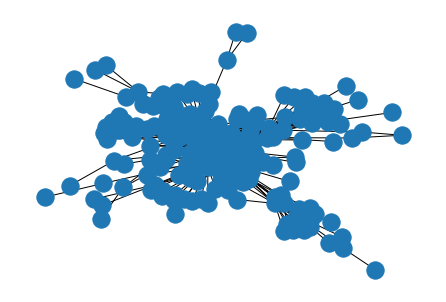

In [ ]:
main()